In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm import tqdm

import neptune.new as neptune

In [2]:
def show_image(data_dir='/Users/nielspace/Documents/data/birds/train/'):
    list_dir = os.listdir(data_dir)
    rand_d = np.random.randint(0, len(list_dir))
    rand_d = list_dir[rand_d]
    img_dir = data_dir+rand_d
    image = os.listdir(img_dir)
    rand_i = np.random.randint(len(image))
    img_src = img_dir+'/'+image[rand_i]
    img = cv2.imread(img_src)
    resize = cv2.resize(img, (100,100))
    plt.figure(figsize=(10,8))
    plt.imshow(img)
    plt.title(rand_d)
    
    
    plt.axis('off')
    plt.show()

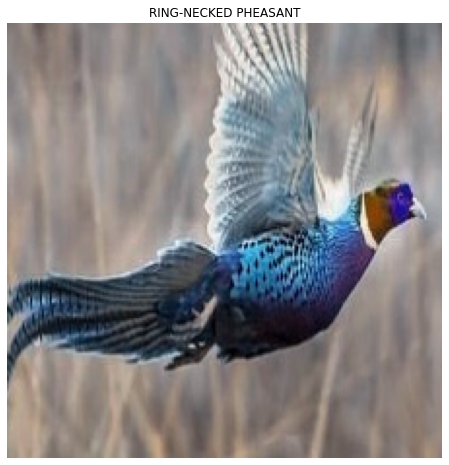

In [3]:
show_image()

# Create Dataset

In [4]:
train_dir = '/Users/nielspace/Documents/data/birds/train/'
val_dir = '/Users/nielspace/Documents/data/birds/valid/'
test_dir = '/Users/nielspace/Documents/data/birds/test/'

bs = 1
crop_size = 64

def dataset(bs, crop_size, sample_size='full'):
    transformations = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(crop_size),
        torchvision.transforms.CenterCrop(crop_size),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    if sample_size == 'full':
        train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
        test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
        valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
        
        train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
        test_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
        test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)
    
    else:
        train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=transformations)
        test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=transformations)
        valid_data = torchvision.datasets.ImageFolder(root=val_dir, transform=transformations)
        
        indices = torch.arange(sample_size)
        p20_v = (20/100)*len(valid_data)
        p20_v = torch.arange(p20_v)
        p20_t = (20/100)*len(test_data)
        p20_t = torch.arange(p20_t)
        
        assert len(indices) > len(p20_v), "Training samples should be more than validation and test samples"
        train_data = torch.utils.data.Subset(train_data, indices)
        test_data = torch.utils.data.Subset(test_data, p20_t)
        valid_data = torch.utils.data.Subset(valid_data, p20_v)
        
        train_data = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=bs)
        valid_data = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=bs)
        test_data = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=bs)
    
    return train_data, valid_data, test_data

In [5]:
train_data, val_data, test_data = dataset(bs,100, 1000)

In [6]:
train_data.batch_size

1

In [7]:
len(train_data), len(val_data)

(1000, 400)

# Data Modeling

In [10]:
from attention import Attention
from transformer import Transformer, ViT

import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange
import time

In [11]:
model = ViT(
    image_size=100, 
    patch_size=10, 
    num_classes=400, 
    channels=3, 
    dim=64, 
    depth=6, 
    heads=8, 
    mlp_dim=128,
)

# Todo

1. Embedding
2. Encoder

In [121]:
from torch.nn.modules.utils import _pair
class Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, img_size, in_channels=3):
        super(Embeddings, self).__init__()
        img_size = _pair(img_size)
        
        patch_size = _pair((16,16))
        n_patches = (img_size[0] // 16) * (img_size[1] // 16)
        
        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=768,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches+1, 768))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, 768))

        self.dropout = Dropout(0.1)

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = self.patch_embeddings(x)
        x = x.flatten(2)
        x = x.transpose(-1, -2)
        x = torch.cat((cls_tokens, x), dim=1)

        embeddings = x+self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings

x = torch.randn(1,3*16*16)
x = x.reshape(1,3, 16, 16)
e = Embeddings(16)
e(x).shape

torch.Size([1, 2, 768])

In [153]:
import math
class Attention(nn.Module):
    def __init__(self, num_heads, hidden_size, attention_dropout_rate):
        super(Attention, self).__init__()
        self.num_attention_heads = 12
        self.attention_head_size = int(768 / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = Linear(hidden_size, self.all_head_size)
        self.key = Linear(hidden_size, self.all_head_size)
        self.value = Linear(hidden_size, self.all_head_size)

        self.out = Linear(hidden_size, self.all_head_size)
        self.attn_dropout = Dropout(attention_dropout_rate)
        self.proj_dropout = Dropout(attention_dropout_rate)

        self.softmax = torch.nn.Softmax(dim=-1)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = self.softmax(attention_scores)
        weights = attention_probs 
        attention_probs = self.attn_dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        attention_output = self.out(context_layer)
        attention_output = self.proj_dropout(attention_output)
        return attention_output, weights
    
A = Attention(num_heads=12, hidden_size=768, attention_dropout_rate=0.1)
A(e(x))[0].shape, A(e(x))[1].shape

(torch.Size([1, 2, 768]), torch.Size([1, 12, 2, 2]))

In [133]:
# norm(emb(x))
class Block(nn.Module):
    def __init__(self):
        super(Block, self).__init__()
        self.hidden_size = 768
        self.attention_norm = LayerNorm(768, eps=1e-6)
        self.ffn_norm = LayerNorm(768, eps=1e-6)
#         self.ffn = Mlp(config)
        self.attn = Attention(num_heads=12, hidden_size=768, attention_dropout_rate=0.1)

    def forward(self, x):
        h = x
        x = self.attention_norm(x)
        x, weights = self.attn(x)
#         x = x + h

#         h = x
#         x = self.ffn_norm(x)
#         x = self.ffn(x)
#         x = x + h
        return x

b=Block()
b(e(x)).shape

RuntimeError: shape '[1, 2, 12, 64]' is invalid for input of size 288

In [103]:
class Encoder(nn.Module):
    def __init__(self, num_layers=12):
        super(Encoder, self).__init__()
        self.layer = nn.ModuleList()
        self.encoder_norm = LayerNorm(768, eps=1e-6)
        for _ in range(num_layers):
            layer = Block(config, vis)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, hidden_states):
        attn_weights = []
        for layer_block in self.layer:
            hidden_states, weights = layer_block(hidden_states)
            if self.vis:
                attn_weights.append(weights)
        encoded = self.encoder_norm(hidden_states)
        return encoded, attn_weights

(16, 16)

In [41]:
from torch.nn import CrossEntropyLoss, Dropout, Linear, Conv2d, LayerNorm

A = Complex_attention(num_heads=12, hidden_size=768, num_attention_heads=12, attention_dropout_rate=0.2)
A.__dict__

{'num_attention_heads': 12,
 'attention_head_size': 64,
 'all_head_size': 144,
 'query': Linear(in_features=768, out_features=144, bias=True),
 'key': Linear(in_features=768, out_features=144, bias=True),
 'value': Linear(in_features=768, out_features=144, bias=True),
 'out': Linear(in_features=768, out_features=144, bias=True),
 'attn_dropout': Dropout(p=0.2, inplace=False),
 'proj_dropout': Dropout(p=0.2, inplace=False),
 'softmax': Softmax(dim=-1)}

In [61]:
x = torch.randn(1,3*224*224)
x = x.reshape(1,3, 224, 224)
x = x.unsqueeze(0)
new_x_shape=x.size()[:-1]+(12,64)
new_x_shape
x.view(*new_x_shape)
# A.transpose_for_scores(x)

RuntimeError: shape '[1, 1, 3, 224, 12, 64]' is invalid for input of size 150528

In [53]:
x.view(*1, 16, 12, 64)

TypeError: view() argument after * must be an iterable, not int

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
# run = neptune.init(
#     project="nielspace/ViT-bird-classification",
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkYjRhYzI0Ny0zZjBmLTQ3YjYtOTY0Yi05ZTQ4ODM3YzE0YWEifQ==",
# )

https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-15


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [13]:
def train_Engine(n_epochs,
                 train_data,
                 val_data,
                 model,
                 optimizer,
                 loss_fn,
                 device,
                 train_loss_history,
                 val_loss_history,
                 monitoring=True):

    yhat = []
    y_o = []
    for epoch in range(1, n_epochs + 1):
        print('Epoch:', epoch)
        for i, (data, target) in tqdm(enumerate(train_data), total=len(train_data), desc="Training"):
            total_samples = len(train_data.dataset)
            
            #device
            model = model.to(device)
            x = data.to(device)
            y = target.to(device)
            
            optimizer.zero_grad()
            output = F.log_softmax(model.forward(x), dim=1)

            y_o.append(y)
            yhat.append(output)
            
            accuracy = torch.sum(output == y).item()/len(train_data)
            loss = F.nll_loss(output, y)
            loss.backward()
            optimizer.step()
            
            if monitoring:
                run['Training_loss'].log(loss.item())
                run['Training_acc'].log(accuracy.item())

            
        model.eval()
        total_samples = len(valid_data.dataset)
        correct_samples = 0
        total_loss = 0

        with torch.no_grad():
            for i, (data, target) in tqdm(enumerate(valid_data), total=len(train_data), desc="Valuation"):
                
                model = model.to(device)
                x = data.to(device)
                y = target.to(device)

                output = F.log_softmax(model(x), dim=1)
                val_loss = F.nll_loss(output, y, reduction='sum')
                _, pred = torch.max(output, dim=1)
                
                total_loss += val_loss.item()
                correct_samples += pred.eq(y).sum()
                val_acc = torch.sum(pred == y).item()/len(val_data)
                avg_loss = total_loss / total_samples
                val_loss_history.append(avg_loss)

                if monitoring:
                    run['Val_loss'].log(avg_loss)
                    run['Val_accuracy'].log(val_acc)


In [ ]:
train_Engine(n_epochs=2,
             train_data=train_data,
             val_data=val_data,
             model=model,
             optimizer=optimizer,
             loss_fn='nll_loss',
             device='mps',
             train_loss_history=[],
             val_loss_history=[],)


Epoch: 1


Training:   0%|                                                                                | 0/1000 [00:00<?, ?it/s]

In [1]:
run.stop()

NameError: name 'run' is not defined

In [32]:
run["parameters"] = params

for epoch in range(10):
    run["train/loss"].log(0.9 ** epoch)

run["eval/f1_score"] = 0.66

run.stop()

https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-1


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 22 operations to synchronize with Neptune. Do not kill this process.
All 22 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/nielspace/ViT-bird-classification/e/VIT-1


In [10]:
from config import Config

In [19]:
PARAMS = {}
for key, val in Config.__dict__.items():
    if key not in ['__module__', '__dict__', '__weakref__', '__doc__']:
        PARAMS[key] = val
        
PARAMS

{'IMG_SIZE': 224,
 'CROP_SIZE': 224,
 'BATCH_SIZE': 128,
 'N_SAMPLES': 400,
 'N_TRAIN': 400,
 'N_VAL': 400,
 'N_TEST': 400,
 'LR': 0.003,
 'OPIMIZER': 'Adam',
 'N_CLASSES': 400,
 'N_CHANNELS': 3,
 'LATENT_DIM': 100,
 'N_ITER': 400,
 'OUTPUT': 'softmax',
 'LOSS_FN': 'nll_loss',
 'DEVICE': ['cpu', 'mps', 'cuda'],
 'N_EPOCHS': 100,
 'TRAIN_LOSS_HISTORY': [],
 'VAL_LOSS_HISTORY': []}

In [30]:
Config.__dict__

mappingproxy({'__module__': 'config',
              'IMG_SIZE': 224,
              'CROP_SIZE': 224,
              'BATCH_SIZE': 128,
              'N_SAMPLES': 400,
              'N_TRAIN': 400,
              'N_VAL': 400,
              'N_TEST': 400,
              'LR': 0.003,
              'OPIMIZER': 'Adam',
              'N_CLASSES': 400,
              'N_CHANNELS': 3,
              'LATENT_DIM': 100,
              'N_ITER': 400,
              'OUTPUT': 'softmax',
              'LOSS_FN': 'nll_loss',
              'DEVICE': ['cpu', 'mps', 'cuda'],
              'N_EPOCHS': 100,
              'TRAIN_LOSS_HISTORY': [],
              'VAL_LOSS_HISTORY': [],
              '__dict__': <attribute '__dict__' of 'Config' objects>,
              '__weakref__': <attribute '__weakref__' of 'Config' objects>,
              '__doc__': None})